In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re

Only keeping the necessary columns.

In [ ]:
data = pd.read_csv('/content/Sentiment.csv')

In [ ]:
data = data[['sentiment', 'text', 'candidate']]

In [ ]:
data.head()

,sentiment,text,candidate
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about...,No candidate mentioned
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdeb...,Scott Walker
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the ...,No candidate mentioned
3,Positive,RT @RobGeorge: That Carly Fiorina is trending ...,No candidate mentioned
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Donald Trump


#**Bar Chart**

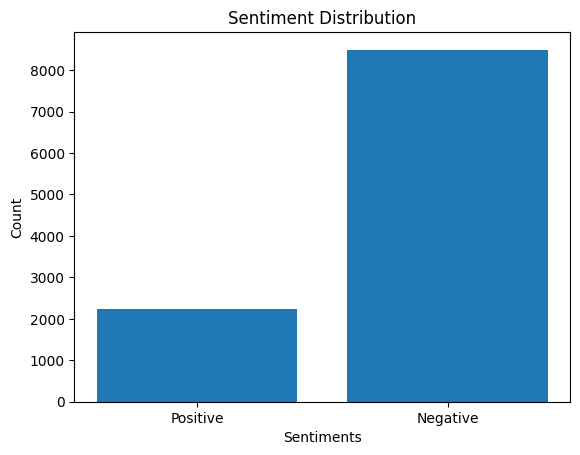

In [ ]:
import matplotlib.pyplot as plt

positive = data[data["sentiment"] == "Positive"]
negative = data[data["sentiment"] == "Negative"]

positive_count = len(positive)
negative_count = len(negative)

sentiments = ["Positive", "Negative"]
counts = [positive_count, negative_count]

plt.bar(sentiments, counts)
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


#**World Cloud**

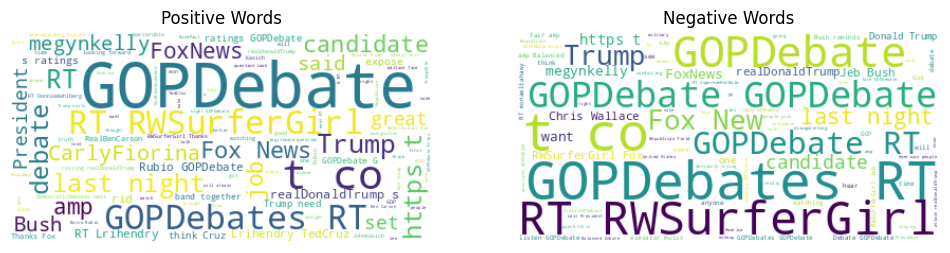

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter texts based on sentiments
positive_texts = ' '.join(data[data["sentiment"] == "Positive"]["text"])
negative_texts = ' '.join(data[data["sentiment"] == "Negative"]["text"])

# Create word clouds for positive and negative sentiments
wordcloud_positive = WordCloud(background_color='white').generate(positive_texts)
wordcloud_negative = WordCloud(background_color='white').generate(negative_texts)

# Plot the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Words')
plt.axis('off')

plt.show()


#** BUSINESS QUESTION FROM DATASET-> ADDED GRAPH THAT SHOWS SENTIMENTS AS PER CANDIDATES**

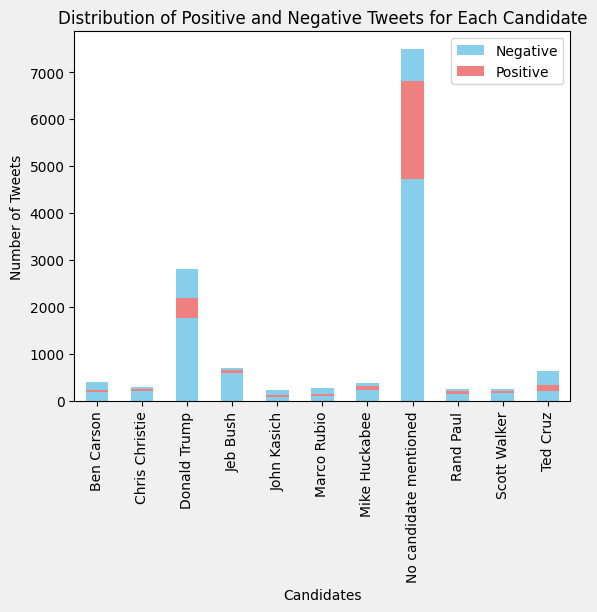

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'data' with 'text', 'sentiment', 'candidate' columns
# Example structure: data = pd.DataFrame({'text': ['...', '...'], 'sentiment': ['positive', 'negative'], 'candidate': ['Candidate1', 'Candidate2']})

# Create a DataFrame with counts of positive and negative tweets for each candidate
sentiment_counts = data.groupby(['candidate', 'sentiment']).size().unstack().fillna(0)

# Plot a stacked bar chart
fig, ax = plt.subplots()

sentiment_counts.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'lightcoral'])

# Add labels and title to the chart
ax.set_xlabel('Candidates')
ax.set_ylabel('Number of Tweets')
ax.set_title('Distribution of Positive and Negative Tweets for Each Candidate')

# Add legend
ax.legend(['Negative', 'Positive'], loc='upper right')

# Set background color
fig.set_facecolor('#F0F0F0')  # Replace '#F0F0F0' with your desired background color

# Show the plot
plt.show()


In [ ]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size) #Positive
print(data[ data['sentiment'] == 'Negative'].size) #Negative

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 40, batch_size=batch_size, verbose = 2)

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):

    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1

    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

In [ ]:
twt = ["watching the primetime gopdebate this afternoon i think bencarson2016 was the real winner quiet but effective"]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")